In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, patches
from scipy import signal

from tbd_eeg.data_analysis.eegutils import *
from tbd_eeg.data_analysis.Utilities import utilities as utils

# %matplotlib widget

In [2]:
epoch_cms = {
    'pre' : cm.Reds,
    'iso_high' : cm.PuOr,
    'iso_low' : cm.PuOr_r,
    'early_recovery': cm.Blues,
    'late_recovery' : cm.Greens
}

In [3]:
# # if loading data as numpy arrays, use this cell

# data_folder = r"/allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/"

# # set the sample_rate for all data analysis
# sample_rate = 2500

# exp = EEGexp(data_folder)

# # load data
# eegdata, timestamps = exp.load_eegdata(frequency=sample_rate, return_type='np')
# running_speed, running_time = exp.load_running(return_type='np')
# iso, iso_time = exp.load_analog_iso(return_type='np')

In [4]:
# # the next cell loads data as pandas dataframes, which are easier to work with

data_folder = r"/allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/"

# set the sample_rate for all data analysis
sample_rate = 2500

# load experiment metadata and eeg data
exp = EEGexp(data_folder)

eegdata = exp.load_eegdata(frequency=sample_rate, return_type='pd')
running_speed = exp.load_running(return_type='pd')
iso = exp.load_analog_iso(return_type='pd')

######################################################################################################
# locate valid channels (some channels can be disconnected and we want to ignore them in the analysis)

print('Identifying valid channels...')
median_amplitude = eegdata[:sample_rate*300].apply(
    utils.median_amplitude, raw=True, axis=0, distance=sample_rate
)
valid_channels = median_amplitude.index[median_amplitude < 2000].values
print('The following channels seem to be correctly connected and report valid data:')
print(list(valid_channels))

# automatically annotate anesthesia epochs
iso_first_on = (iso>4).idxmax()
iso_first_mid = ((iso[iso.index>iso_first_on]>1)&(iso[iso.index>iso_first_on]<4)).idxmax()
iso_first_off = (iso>1)[::-1].idxmax()

print('iso on at', iso_first_on)
print('iso reduced at', iso_first_mid)
print('iso off at', iso_first_off)

# annotate artifacts with power in high frequencies
print('Annotating artifacts...')
hf_annots = pd.Series(
    eegdata[valid_channels].apply(
        find_hf_annotations, axis=0,
        sample_rate=sample_rate, fmin=300, pmin=0.25
    ).mean(axis=1),
    name='artifact'
)
recovery_first_jump = (hf_annots>4)[hf_annots.index>iso_first_off].idxmax()

epochs = pd.Series(
    index = [iso_first_on-0.001, iso_first_on+0.001, iso_first_mid-0.001,
             iso_first_mid+0.001, iso_first_off-0.001, iso_first_off+0.001,
             recovery_first_jump-0.001, recovery_first_jump+0.001,],
    data=['pre', 'iso_high', 'iso_high', 'iso_low', 'iso_low',
          'early_recovery', 'early_recovery', 'late_recovery'],
    dtype=pd.CategoricalDtype(
        categories=['pre', 'iso_high', 'iso_low', 'early_recovery', 'late_recovery'],
        ordered=True
    )
)

print('The following dataframe shows start and end times of anesthesia epochs:')
epochs

/home/saurabh.gandhi/Projects/.env_zz/lib/python3.7/site-packages/allensdk/brain_observatory/sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


Identifying valid channels...
The following channels seem to be correctly connected and report valid data:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
iso on at 672.736
iso reduced at 971.504
iso off at 1772.992
Annotating artifacts...


672.73500                pre
672.73700           iso_high
971.50300           iso_high
971.50500            iso_low
1772.99100           iso_low
1772.99300    early_recovery
2117.20354    early_recovery
2117.20554     late_recovery
dtype: category
Categories (5, object): [pre < iso_high < iso_low < early_recovery < late_recovery]

In [6]:
# get artifact times
thresh = 4
invalid_times = (hf_annots>thresh)

print('This series shows times at which data might not be valid:')
invalid_times[invalid_times]

This series shows times at which data might not be valid:


74.05014      True
96.36774      True
138.59614     True
140.12774     True
146.91054     True
              ... 
3052.35574    True
3053.01214    True
3053.88734    True
3054.32494    True
3054.76254    True
Name: artifact, Length: 589, dtype: bool

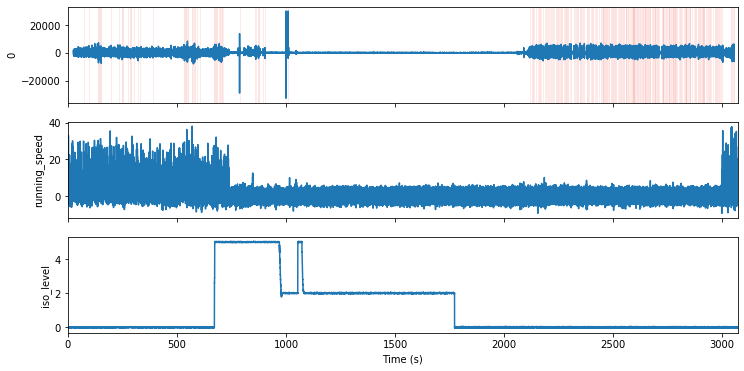

In [7]:
# plot a channel, running speed and iso
f, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for ax, data in zip(axes, [eegdata[0], running_speed, iso]):
    data.plot(ax=ax)
    ax.set_ylabel(data.name)
ax.set_xlabel('Time (s)')

# show artifact windows
# the get_windows function is defined in eegutils.py
for win in get_windows(invalid_times, coalesce=3, min_length=0.4):
    axes[0].axvspan(win[0], win[1], color=cm.Reds(0.6, 0.1));